Importing libraries 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

Reading and cleaning our data

In [15]:
df = pd.read_csv("insurance.csv")
print(df)

      age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]


In [16]:
#(rows, columns)
df.shape 

(1338, 7)

In [17]:
#checking for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [18]:
#checking for duplicate rows
df.duplicated().sum()

np.int64(1)

In [19]:
#statistical summary of the dataset
df.describe() 

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [20]:
#listing all columns
df.columns 

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

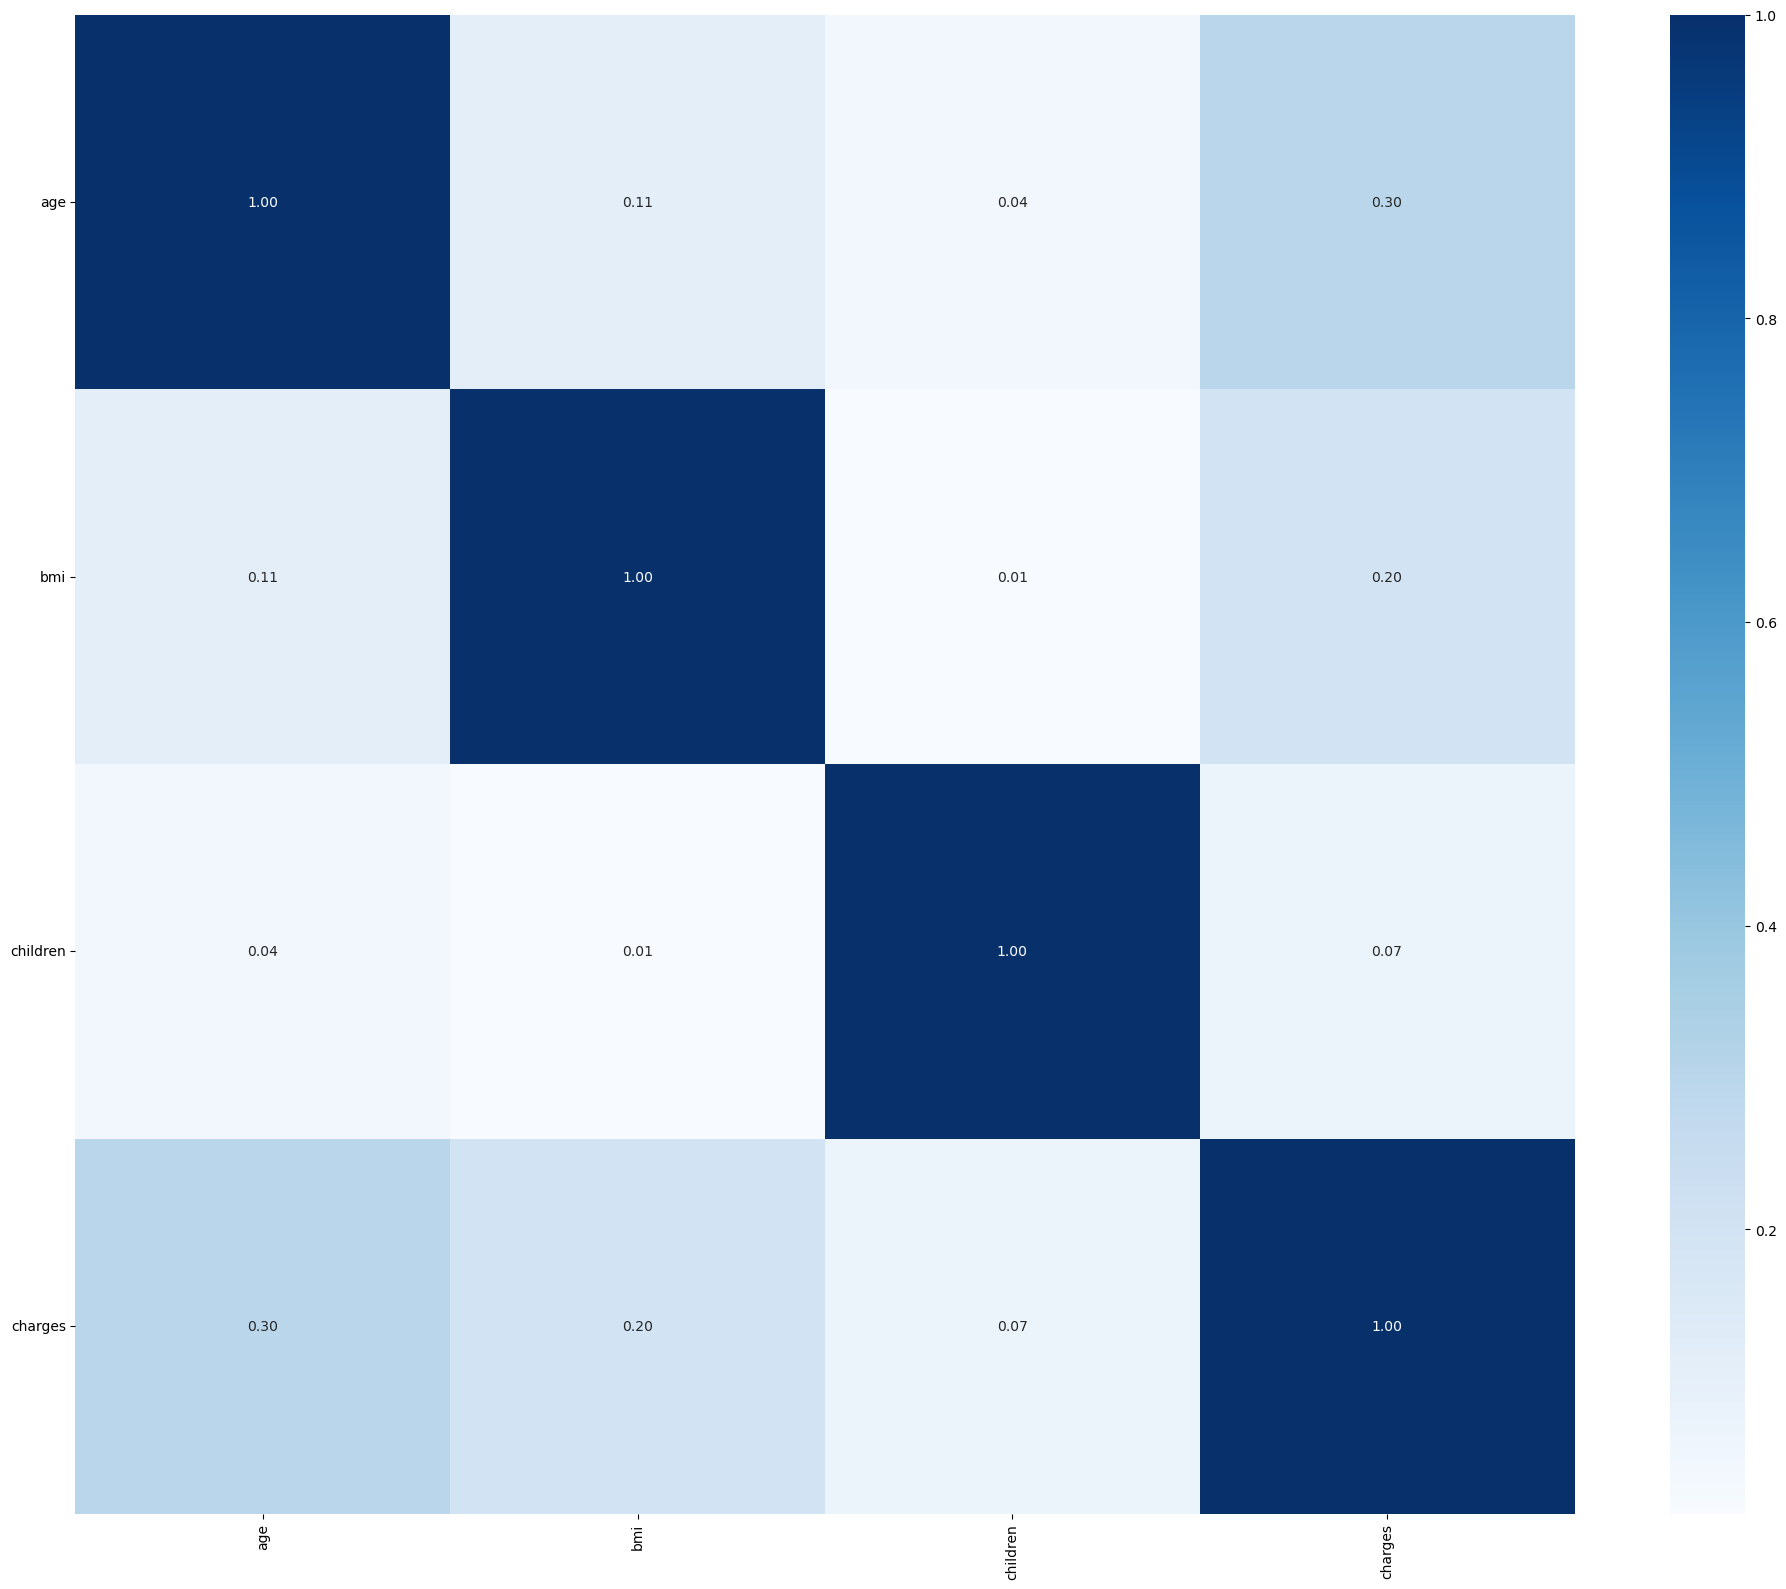

In [21]:
#checking if any of the numberical variables have high correlation
corr = df.select_dtypes(include="number").corr()

#creating bigger figure
plt.figure(figsize=(20, 16)) 
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [22]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Define y (target) and x (dropping columns)

In [23]:
#split off target first
y = df["charges"]
X = df.drop(columns=["charges"]) #remove other target-like columns

print(X.columns)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')


Automatically preprocesses the dataset by one-hot encoding categorical features and scaling numerical features using a ColumnTransformer

In [24]:
#detect columns from X (not df - only looking at data where target has been removed)
categorical_cols = X.select_dtypes(include=["object"]).columns 
numeric_cols = X.select_dtypes(exclude=["object"]).columns

#build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols), #onehot encoding
        ("num", StandardScaler(), numeric_cols), #scales numerical features so income (e.g. 80,000) does not dominates bmi (e.g. 22) barely matters in regression.
    ],
    remainder="drop",
)


Split/test data, Linear regression 

In [25]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#pipeline (running preprocessor + model)
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

#train the model
model.fit(X_train, y_train)

print("Train R²:", model.score(X_train, y_train))
print("Test  R²:", model.score(X_test, y_test))

Train R²: 0.7417255854683333
Test  R²: 0.7835929767120737


DecisonTreeRegressor

In [44]:
tree = DecisionTreeRegressor(
    max_depth=3,         #limit how deep it can grow
    min_samples_split=20, 
    min_samples_leaf=10,
    random_state=42
)
tree_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", tree)
])

tree_pipeline.fit(X_train, y_train)

print("Train R2:", tree_pipeline.score(X_train, y_train))
print("Test  R2:", tree_pipeline.score(X_test, y_test))

Train R2: 0.8536698744663597
Test  R2: 0.8530572866320028


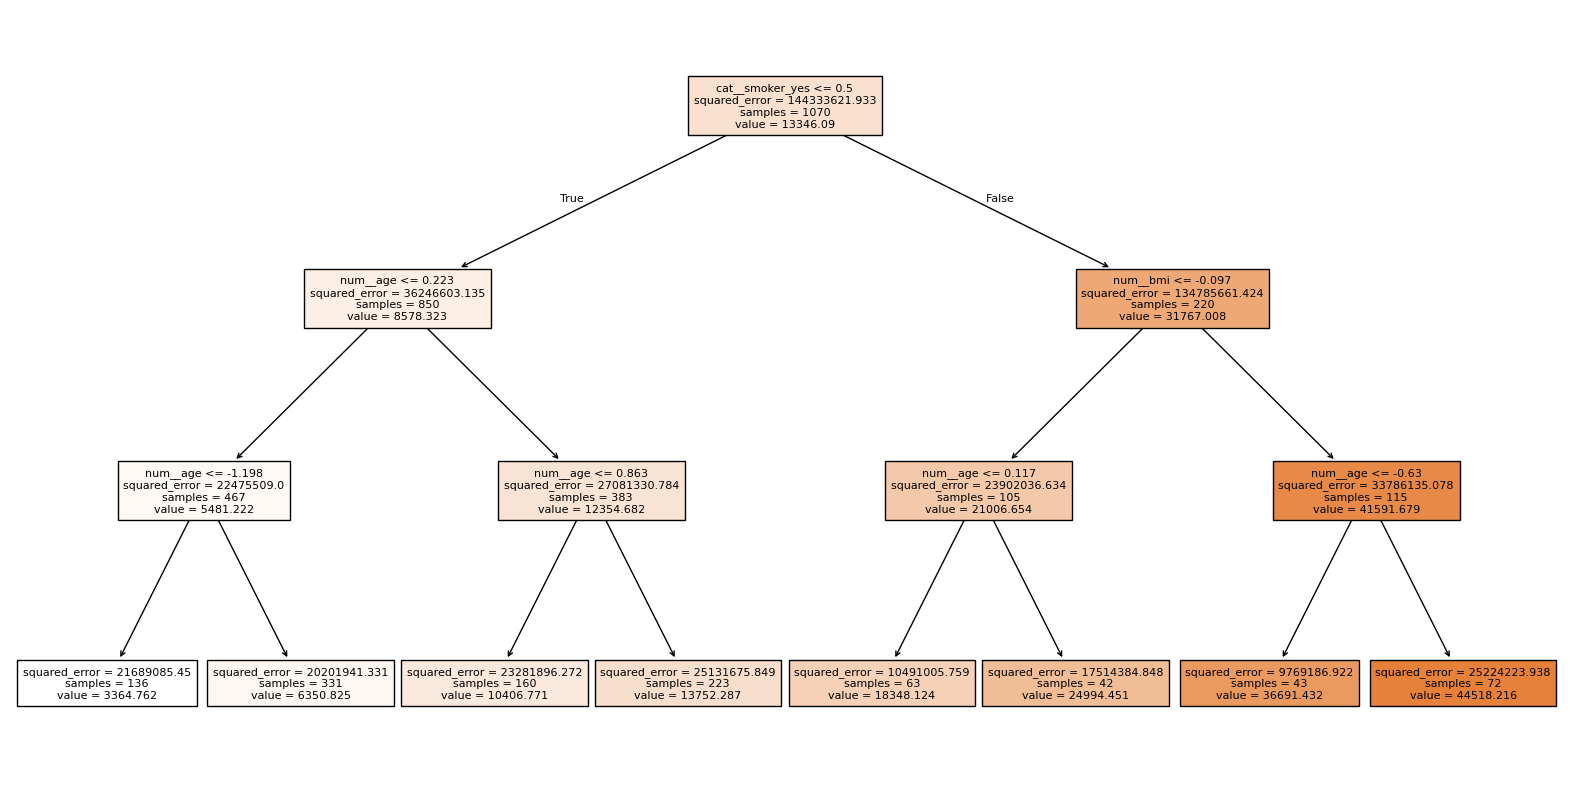

In [45]:
from sklearn import tree

feature_names = tree_pipeline.named_steps["preprocessor"].get_feature_names_out() #get feature names after preprocessing


plt.figure(figsize=(20, 10)) #create a bigger figure for better readability

tree.plot_tree(
    tree_pipeline.named_steps["regressor"], #access the decision tree model from the pipeline
    feature_names=feature_names, #use the feature names from preprocessor
    filled=True,
    fontsize=8
)

plt.show()

Defining our regressor-function that calls other models

In [46]:
def evaluate_regressor(name, model, X_train, X_test, y_train, y_test): #evaluate regression model performance
    y_pred_train = model.predict(X_train)  
    y_pred_test = model.predict(X_test)     

    mse_train = mean_squared_error(y_train, y_pred_train) #calculate mean squared error
    mse_test = mean_squared_error(y_test, y_pred_test)

    rmse_train = np.sqrt(mse_train) #calculate root mean squared error
    rmse_test = np.sqrt(mse_test)

    mae_train = mean_absolute_error(y_train, y_pred_train) #calculate mean absolute error
    mae_test = mean_absolute_error(y_test, y_pred_test)

    r2_train = r2_score(y_train, y_pred_train) #calculate R-squared
    r2_test = r2_score(y_test, y_pred_test)

    print(f"{name}")
    print(f"Train: RMSE={rmse_train:.2f}, MAE={mae_train:.2f}, R²={r2_train:.3f}") 
    print(f"Test:  RMSE={rmse_test:.2f}, MAE={mae_test:.2f}, R²={r2_test:.3f}")
    print()


Evaluation of linear regression and decision tree

In [29]:
evaluate_regressor("Linear Regression", model, X_train, X_test, y_train, y_test) #evaluate linear regression model
evaluate_regressor("Decision Tree", tree_pipeline, X_train, X_test, y_train, y_test) #evaluate decision tree model

Linear Regression
Train: RMSE=6105.55, MAE=4208.23, R²=0.742
Test:  RMSE=5796.28, MAE=4181.19, R²=0.784

Decision Tree
Train: RMSE=4247.72, MAE=2463.93, R²=0.875
Test:  RMSE=4547.86, MAE=2718.62, R²=0.867



Ridge and Lasso using 5-fold cross-validation

In [30]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

ridge = Pipeline(steps=[ #create ridge regression pipeline 
    ("preprocessor", preprocessor),
    ("regressor", RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5))
])

lasso = Pipeline(steps=[ #create lasso regression pipeline
    ("preprocessor", preprocessor),
    ("regressor", LassoCV(alphas=[0.001, 0.01, 0.1, 1.0], cv=5, max_iter=5000))
])

ridge.fit(X_train, y_train) 
lasso.fit(X_train, y_train)

evaluate_regressor("Ridge Regression", ridge, X_train, X_test, y_train, y_test) 
evaluate_regressor("Lasso Regression", lasso, X_train, X_test, y_train, y_test)

print("Ridge best alpha:", ridge.named_steps["regressor"].alpha_)
print("Lasso best alpha:", lasso.named_steps["regressor"].alpha_)


Ridge Regression
Train: RMSE=6105.79, MAE=4217.47, R²=0.742
Test:  RMSE=5800.46, MAE=4193.20, R²=0.783

Lasso Regression
Train: RMSE=6105.55, MAE=4208.38, R²=0.742
Test:  RMSE=5797.04, MAE=4182.22, R²=0.784

Ridge best alpha: 1.0
Lasso best alpha: 1.0


Bagging

In [31]:
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train) 

evaluate_regressor("Random Forest", rf, X_train, X_test, y_train, y_test)


Random Forest
Train: RMSE=3699.30, MAE=2041.74, R²=0.905
Test:  RMSE=4362.39, MAE=2479.49, R²=0.877



Finding the most important features in RandomForest

In [32]:
rf_reg = rf.named_steps["regressor"]
importances = rf_reg.feature_importances_

feature_names = rf.named_steps["preprocessor"].get_feature_names_out()

import pandas as pd

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(importance_df.head(20))


                 feature  importance
1        cat__smoker_yes    0.664992
6               num__bmi    0.190530
5               num__age    0.125701
7          num__children    0.010893
0          cat__sex_male    0.002820
3  cat__region_southeast    0.002027
4  cat__region_southwest    0.001627
2  cat__region_northwest    0.001411


Boosting

In [33]:

gbr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])


gbr.fit(X_train, y_train)

evaluate_regressor("Gradient Boosting", gbr, X_train, X_test, y_train, y_test)



Gradient Boosting
Train: RMSE=3815.32, MAE=2097.36, R²=0.899
Test:  RMSE=4309.94, MAE=2457.01, R²=0.880



KNearestNeighbor

In [34]:
# #PRØV FORSKELLIGE K-VÆRDIER I KNN (F.EKS. 3, 7, 10) OG SAMMENLIGN RESULTATERNE (SMALL K VÆRDIER KAN GIVE OVERFITTING (HØJ VARIANS), STØRRE K VÆRDIER KAN GIVE UNDERFITTING (BIAS))
# from sklearn.neighbors import KNeighborsRegressor

# k_values = [1, 3, 5, 7, 10, 15] #different k values to try
# for k in k_values: #loop through k values
#     knn_k = Pipeline(steps=[ #create KNN regression pipeline
#         ("preprocessor", preprocessor),
#         ("regressor", KNeighborsRegressor(n_neighbors=k))
#     ])
#     knn_k.fit(X_train, y_train)
#     evaluate_regressor(f"KNN (k={k})", knn_k, X_train, X_test, y_train, y_test) 


GridSearch KNN - systematic hyperparameter tuning with cross-validation

In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

#hyperparameter tuning for KNN
param_grid_knn = {
    "regressor__n_neighbors": [3, 5, 7, 10, 12, 15, 20, 30, 40, 100, 200], #try different k values
    "regressor__weights": ["uniform", "distance"] #try both uniform and distance weighting, where closer neighbors have more influence
}

#create KNN regression pipeline
knn_base = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", KNeighborsRegressor())
])

#grid search with 5-fold cross-validation
grid_knn = GridSearchCV(
    knn_base,
    param_grid_knn,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

#fit grid search
grid_knn.fit(X_train, y_train)
print("Best params KNN:", grid_knn.best_params_)

evaluate_regressor("KNN (tuned)", grid_knn.best_estimator_, X_train, X_test, y_train, y_test)


Best params KNN: {'regressor__n_neighbors': 3, 'regressor__weights': 'distance'}
KNN (tuned)
Train: RMSE=494.21, MAE=29.57, R²=0.998
Test:  RMSE=6494.98, MAE=3633.20, R²=0.728



Baseline model - skal den stå her?

In [36]:
from sklearn.dummy import DummyRegressor
baseline = Pipeline(steps=[
    ("preprocessor", preprocessor),      
    ("regressor", DummyRegressor(strategy="mean")) #baseline predicting mean value
])

baseline.fit(X_train, y_train) #fit baseline model

evaluate_regressor("Baseline (mean)", baseline, X_train, X_test, y_train, y_test)

Baseline (mean)
Train: RMSE=12013.89, MAE=9000.56, R²=0.000
Test:  RMSE=12465.61, MAE=9593.34, R²=-0.001



Creating a table for all of our results

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#list to store results from all models
results = []

def evaluate_regressor(name, model, X_train, X_test, y_train, y_test):
    #printing metrics and storing them in the global `results` list
    #predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    #errors
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    #print nicely
    print(f"{name}")
    print(f"Train: RMSE={rmse_train:.2f}, MAE={mae_train:.2f}, R²={r2_train:.3f}")
    print(f"Test:  RMSE={rmse_test:.2f}, MAE={mae_test:.2f}, R²={r2_test:.3f}")
    print()

    #store in results list for later DataFrame
    results.append({
        "model": name,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "mae_train": mae_train,
        "mae_test": mae_test,
        "r2_train": r2_train,
        "r2_test": r2_test
    })

evaluate_regressor("Linear Regression", model, X_train, X_test, y_train, y_test)
evaluate_regressor("Baseline (mean)", baseline, X_train, X_test, y_train, y_test)
evaluate_regressor("Decision Tree", tree_pipeline, X_train, X_test, y_train, y_test)
evaluate_regressor("Ridge Regression", ridge, X_train, X_test, y_train, y_test)
evaluate_regressor("Lasso Regression", lasso, X_train, X_test, y_train, y_test)
evaluate_regressor("Random Forest", rf, X_train, X_test, y_train, y_test)
evaluate_regressor("Gradient Boosting", gbr, X_train, X_test, y_train, y_test)
evaluate_regressor("Grid KNN", grid_knn, X_train, X_test, y_train, y_test)


from IPython.display import display

results_df = pd.DataFrame(results)

#round for nicer display
results_df_rounded = results_df.copy()
results_df_rounded[["rmse_train","rmse_test","mae_train","mae_test","r2_train","r2_test"]] = \
    results_df_rounded[["rmse_train","rmse_test","mae_train","mae_test","r2_train","r2_test"]].round(3)

#sort by best (lowest) test RMSE and display as a table
display(results_df_rounded.sort_values("rmse_test"))

Linear Regression
Train: RMSE=6105.55, MAE=4208.23, R²=0.742
Test:  RMSE=5796.28, MAE=4181.19, R²=0.784

Baseline (mean)
Train: RMSE=12013.89, MAE=9000.56, R²=0.000
Test:  RMSE=12465.61, MAE=9593.34, R²=-0.001

Decision Tree
Train: RMSE=4247.72, MAE=2463.93, R²=0.875
Test:  RMSE=4547.86, MAE=2718.62, R²=0.867

Ridge Regression
Train: RMSE=6105.79, MAE=4217.47, R²=0.742
Test:  RMSE=5800.46, MAE=4193.20, R²=0.783

Lasso Regression
Train: RMSE=6105.55, MAE=4208.38, R²=0.742
Test:  RMSE=5797.04, MAE=4182.22, R²=0.784

Random Forest
Train: RMSE=3699.30, MAE=2041.74, R²=0.905
Test:  RMSE=4362.39, MAE=2479.49, R²=0.877

Gradient Boosting
Train: RMSE=3815.32, MAE=2097.36, R²=0.899
Test:  RMSE=4309.94, MAE=2457.01, R²=0.880

Grid KNN
Train: RMSE=494.21, MAE=29.57, R²=0.998
Test:  RMSE=6494.98, MAE=3633.20, R²=0.728



,model,rmse_train,rmse_test,mae_train,mae_test,r2_train,r2_test
6,Gradient Boosting,3815.320,4309.942,2097.356,2457.014,0.899,0.880
5,Random Forest,3699.296,4362.394,2041.738,2479.487,0.905,0.877
2,Decision Tree,4247.720,4547.862,2463.927,2718.619,0.875,0.867
0,Linear Regression,6105.545,5796.285,4208.235,4181.194,0.742,0.784
4,Lasso Regression,6105.551,5797.043,4208.384,4182.221,0.742,0.784
3,Ridge Regression,6105.794,5800.465,4217.471,4193.195,0.742,0.783
7,Grid KNN,494.206,6494.982,29.573,3633.195,0.998,0.728
1,Baseline (mean),12013.893,12465.610,9000.556,9593.338,0.000,-0.001


Residual (error) analysis for our chosen regression model

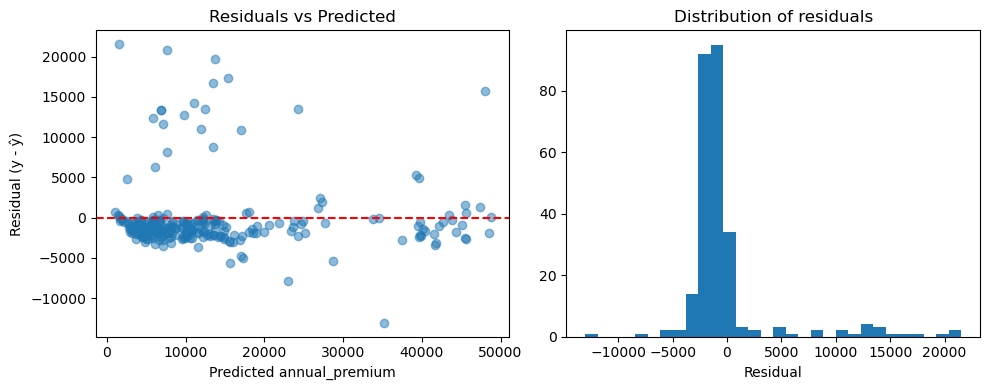

In [38]:
best_model = gbr   #or gbr, or ridge, etc. (den har altså valgt Random Forest som den bedste model)

y_pred = best_model.predict(X_test) #model is predicting values for test-set
residuals = y_test - y_pred #difference between correct value and the model's prediction

plt.figure(figsize=(10,4))

#residuals vs predicted - plotting the graph
plt.subplot(1,2,1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--") #red line indicates no errors - the closer the points are, the better the model has predicted
plt.xlabel("Predicted annual_premium")
plt.ylabel("Residual (y - ŷ)")
plt.title("Residuals vs Predicted")

#histogram of residuals to show the distribution of errors 
plt.subplot(1,2,2)
plt.hist(residuals, bins=30)
plt.xlabel("Residual")
plt.title("Distribution of residuals")

plt.tight_layout()
plt.show()

Prepping for clustering with KMeans

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#scale numeric data so the features hold the same weight
X_num = df[numeric_cols]
X_scaled = StandardScaler().fit_transform(X_num) 

inertias = []
silhouettes = []
k_values = range(2, 8)

#asking KMeans to make k clusters
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)

    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

print("Inertias:", inertias)
print("Silhouettes:", silhouettes)


Inertias: [2997.791572648245, 2155.9399663780164, 1747.0972550981828, 1544.1557500290423, 1275.2876393966326, 1199.060163355476]
Silhouettes: [np.float64(0.2702302787943562), np.float64(0.31217485645494175), np.float64(0.30579497416955537), np.float64(0.28050117273684516), np.float64(0.2905369406013536), np.float64(0.27059114626830794)]


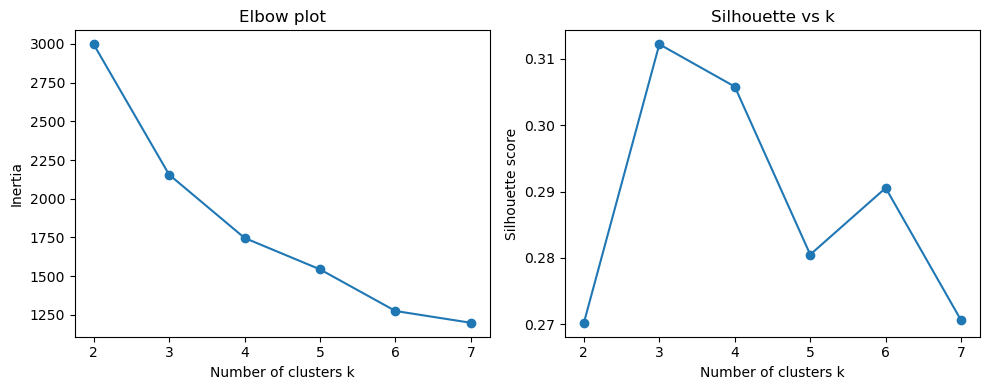

In [40]:
k_values = range(2, 8)

plt.figure(figsize=(10,4))

#elbow (inertia)
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow plot")

#silhouette
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouettes, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs k")

plt.tight_layout()
plt.show()


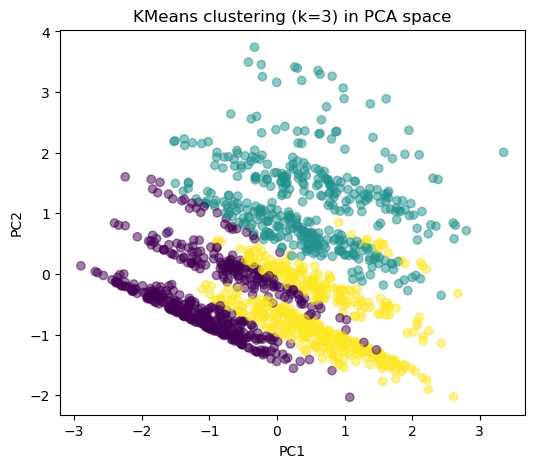

               age        bmi  children
cluster                                
0        25.527835  29.623278  0.435052
1        40.392947  30.973514  2.657431
2        52.723684  31.499671  0.436404


Exception ignored in: <function ResourceTracker.__del__ at 0x106eedbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x108885bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1030a9bc0>
Traceback (most recent call last

In [48]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#choosing k= 2 because that is our best silhouette
best_k = 3

km = KMeans(n_clusters=best_k, random_state=42, n_init=1, max_iter=100)
labels = km.fit_predict(X_scaled)

#project to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled) 

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMeans clustering (k={best_k}) in PCA space")
plt.show()

#taking the mean of every value in each cluster
df_clusters = df.copy()
df_clusters["cluster"] = labels

print(df_clusters.groupby("cluster")[numeric_cols].mean())

Måske ikke pensum: Fairness check by gender (or similar column) AND Fairness / group comparison by age groups

In [42]:
#choose main model for evaluation / fairness checks
#(change to model if we prefer another)
best_model = gbr

#predictions for all rows in the original X
y_pred_all = best_model.predict(X)

df_eval = df.copy()
df_eval["y_true"] = y
df_eval["y_pred"] = y_pred_all

#inspect categorical columns so you know what you can group by
cat_cols = df.select_dtypes(include="object").columns.tolist()
print("Categorical columns in the data:", cat_cols)

#choose a categorical column to check fairness / group differences
#change if our dataset uses another name (e.g. "gender", "smoker", "region")
group_col = "sex"   #try "sex" first; if that doesn't exist, change to one of cat_cols above

if group_col in df_eval.columns:
    print(f"\nAverage true & predicted annual_premium by {group_col}:")
    print(
        df_eval.groupby(group_col)[["y_true", "y_pred"]].mean()
    )
else:
    print(f"\nColumn {group_col!r} not found. "
          f"Set group_col to one of these: {cat_cols}")

#age-group comparison (only if an 'age' column exists)
age_col = "age"     #change if your age column has another name

if age_col in df_eval.columns:
    df_eval["age_bin"] = pd.cut(
        df_eval[age_col],
        bins=[0, 30, 50, 100],
        labels=["<30", "30–50", ">50"]
    )

    print("\nAverage true & predicted annual_premium by age group:")
    print(
        df_eval.groupby("age_bin")[["y_true", "y_pred"]].mean()
    )
else:
    print(f"\nColumn {age_col!r} not found – skipping age-group analysis.")

Categorical columns in the data: ['sex', 'smoker', 'region']

Average true & predicted annual_premium by sex:
              y_true        y_pred
sex                               
female  12569.578844  12566.881275
male    13956.751178  14074.210537

Average true & predicted annual_premium by age group:
               y_true        y_pred
age_bin                            
<30       9397.552051   9445.900496
30–50    13280.774031  13429.122947
>50      18084.987223  18018.521802


/var/folders/qh/2hb6vcy115v9lwgxjwnv1jbr0000gn/T/ipykernel_27179/1468698898.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_eval.groupby("age_bin")[["y_true", "y_pred"]].mean()
